### Посмотрим на топ N grams для архетипов и мотиваторов

In [748]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import deeppavlov
from deeppavlov import build_model, configs
from nltk.tokenize import ToktokTokenizer
from nltk.stem.snowball import RussianStemmer
import nltk, re
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Загрузим все текстовые данные

In [31]:
common = pd.read_csv('COMMON.csv')

In [732]:
common[['value']]

,value
0,xcxc
1,dfxfgd
2,dfhjdh
3,кажется ничему
4,кажется нет
...,...
4692,Курсы по этой программе весьма интересны и име...
4693,Узнал много инструментов для разработки прилож...
4694,"Да очень, много познавательного интересного уз..."
4695,"Есть полезная информация, которую стоит держат..."


#### Агрегируем тексты по юзеру

In [ ]:
texts_for_id = []
for ind in common.untiID.unique():
    user_text = ""
    for text in common[common.untiID==ind]['value']:
        user_text += text + ' '
    texts_for_id.append(user_text)
    

all_text_of_user = pd.DataFrame({'untiID':common.untiID.unique(),
                                'texts':texts_for_id})


### Загрузим результаты диагностик, агрегированные по каждому юзеру

In [733]:
df_train = pd.read_csv('diag_large_train.csv')
df_test = pd.read_csv('diag_test_agg.csv')

df_train.shape, df_test.shape

((1451, 327), (127, 681))

Выделим интересующие нас метрики диагностик в отдельный датафрейм

In [738]:
types=['боец_sum','эксперт_sum','эмпат_sum',
        'избегание негатива, размеренность, безопасность_mean',
          'преодоление сложностей, препятствий_mean',
          'достижение, стремление к лидерству_mean']

df_types =pd.concat([df_train[['untiID']+types],df_test[['untiID']+types]])

In [739]:
def new_tgt(line):
    """Сделаем бинарную разметку: свойственен ли архетип учащемуся (1) или нет (0)"""
    if line > 1:
        return 1
    else:
        return 0
    
def new_tgt_motiv(line):
    """Сделаем бинарную разметку: выражен ли мотиватор у учащегося (1) или нет (0)"""
    if line > 3:
        return 1
    else:
        return 0

In [740]:
df_types['боец'] = df_types['боец_sum'].apply(new_tgt)
df_types['эксперт'] = df_types['эксперт_sum'].apply(new_tgt)
df_types['эмпат'] = df_types['эмпат_sum'].apply(new_tgt)

df_types['избегание_нетагива'] = df_types['избегание негатива, размеренность, безопасность_mean'].apply(new_tgt_motiv)
df_types['преодоление_сложностей'] = df_types['преодоление сложностей, препятствий_mean'].apply(new_tgt_motiv)
df_types['достижение'] = df_types['достижение, стремление к лидерству_mean'].apply(new_tgt_motiv)

### Объединим текстовые данные и результаты диагностк по юзеру

In [741]:
df_ngram = pd.merge(all_text_of_user, df_types, on=['untiID'])
df_ngram.shape

(1527, 15)

## Расширим словарь стопслов

Поможет посмотреть на N грамы без слова, часто встречающихся у всех юзеров.

1. Соберем все слова в одну переменную

In [746]:
text = ""
for i in df_ngram['texts']:
    text += i+' '

2. Оставим только русские слова.
   Подсчитаем частоту каждого слова, исключая традиционные стоп слова (предлоги, союзы итп).

In [749]:
stopwords = stopwords.words('russian')

text = re.sub('[^А-Яа-я]+', ' ', text)
all_words = nltk.tokenize.word_tokenize(text.lower())
all_words_no_stop = [w.lower() for w in all_words if w not in stopwords]
freq_dict = nltk.FreqDist(w.lower() for w in all_words if w not in stopwords)

In [750]:
# уникальных слов в датасете
len(freq_dict)

7493

In [751]:
freq_dict

FreqDist({'очень': 309, 'узнала': 223, 'научилась': 215, 'работы': 183, 'знания': 174, 'ценность': 169, 'это': 161, 'работать': 161, 'работе': 149, 'данных': 134, ...})

3. Уберем топ 600 распространенных слов

In [752]:
stopwords = nltk.corpus.stopwords.words('russian')

for i in range(600):
    common_word = freq_dict.most_common(600)[i][0]
    stopwords.append(common_word)

## N grams для архетипов

In [769]:
def plot_most_common(dict_data ,title):
    df = pd.DataFrame(dict_data)
    df.columns = ['word', 'count']
    plt.figure(figsize=(8, 8))
    sns.set(style="darkgrid")
    sns.barplot(x="count", y="word", data=df, palette='twilight')
    plt.title(title)
    plt.savefig(title+'.png', bbox_inches='tight')
    plt.show()
    

def plot_bigram(diagnostic, title):
    text = ""
    for i in df_ngram[df_ngram[diagnostic]==1]['texts']:
        text += i+' '
    text = re.sub('[^А-Яа-я]+', ' ', text)

    all_words = nltk.tokenize.word_tokenize(text.lower())
    all_words_no_stop = [w.lower() for w in all_words if w not in stopwords]

    freq_dict_trigrams = nltk.FreqDist(nltk.bigrams(w for w in all_words_no_stop))
    plot_most_common(freq_dict_trigrams.most_common(10), title)

Можно отметит, что в для архетипа боец выделяются такие биграмы:
- пути достижения
- публичных выступлений

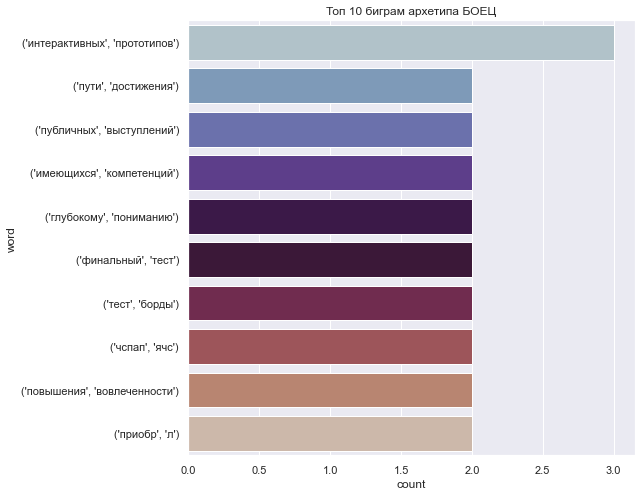

In [760]:
plot_bigram('боец','Топ 10 биграм архетипа БОЕЦ')

В случае с арехтипом эмпат выделяются такие биграмы:
- друг друга
- борьба (со) стрессом
- креативно мыслить

Предоставленное организаторами описание "Эмпата":
Стремится к гармонии, миру, отсутствию онфликта. Позитивно настроен, всегда сопереживает, готов выслушать и помочь. Создает вокруг себя комфортную для себя и окружающих среду, ценит неконфликтное общение. Любит все живое.

Выделенные биграмы перекликаются по смыслу с описанием архетипа.

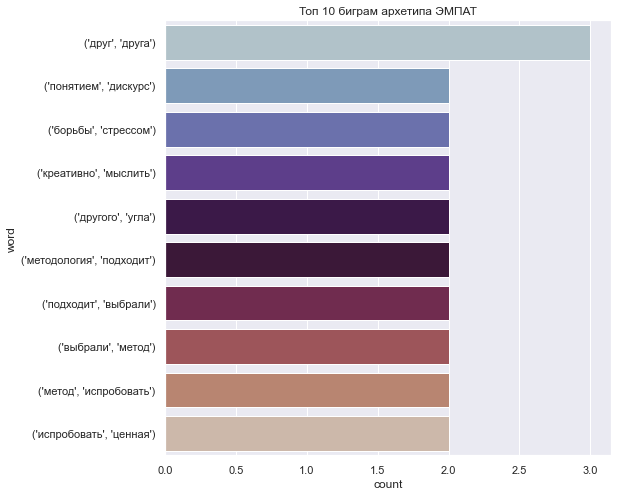

In [761]:
plot_bigram('эмпат','Топ 10 биграм архетипа ЭМПАТ')

Описание Эксперта: Накапливает знания, навыки, компетенции и повышает свою экспертность для того, чтобы быть востребованным. Самостоятельно осваивает новое, анализирует, и систематизирует информацию. __Готов активно делится тем, что знает и умеет, если его слушают.__

Ниже видим, что биграма "публичные выступления" ярче всего выражена именно у этого архетипа

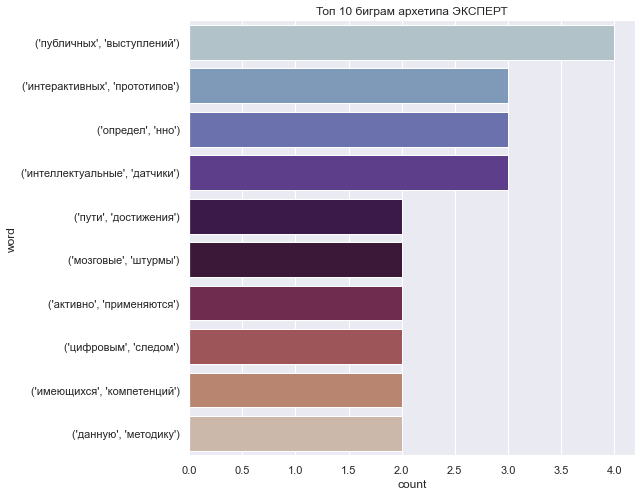

In [762]:
plot_bigram('эксперт','Топ 10 биграм архетипа ЭКСПЕРТ')

## N grams по мотиваторам

In [770]:
def plot_trigrams(diagnostic, title):
    text = ""
    for i in df_ngram[df_ngram[diagnostic]==1]['texts']:
        text += i+' '
    text = re.sub('[^А-Яа-я]+', ' ', text)

    # уберем шумы
    all_words = nltk.tokenize.word_tokenize(text.lower())
    all_words_no_stop = [w.lower() for w in all_words if w not in stopwords]

    # выведем топ 20 н грам
    freq_dict_trigrams = nltk.FreqDist(nltk.trigrams(w for w in all_words_no_stop))
    plot_most_common(freq_dict_trigrams.most_common(10), title)

Описание мотиватора: люди с выраженным мотиватором избегания негатива будут всеми силами стараться уйти от конфликтных и противоречивых ситуаций.

Как видим, среди слов, используемых людьми с выраженным мотиватором "избегание негатива, размеренность, безопасность", выделяются:
- снятие напряжения
- медитация
- самоанализ

Далее можно будет увидеть, что подобные триграмы не встречаются у людей с выраженным мотиватором "достижения, стремление к лидерству".

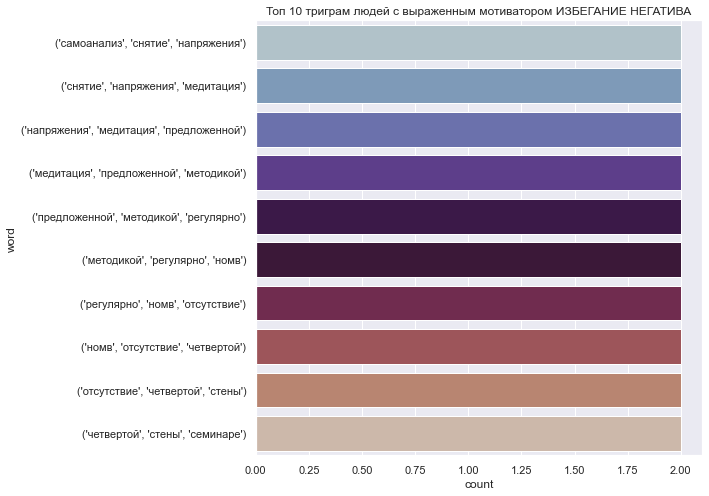

In [771]:
plot_trigrams('избегание_нетагива','Топ 10 триграм людей с выраженным мотиватором ИЗБЕГАНИЕ НЕГАТИВА')

Заметно, что для людей с тягой к достижениям и лидерству характерны такие выражения, как:
- познавательный
- повторения мать учения
- продуктивный
- карьерные способности

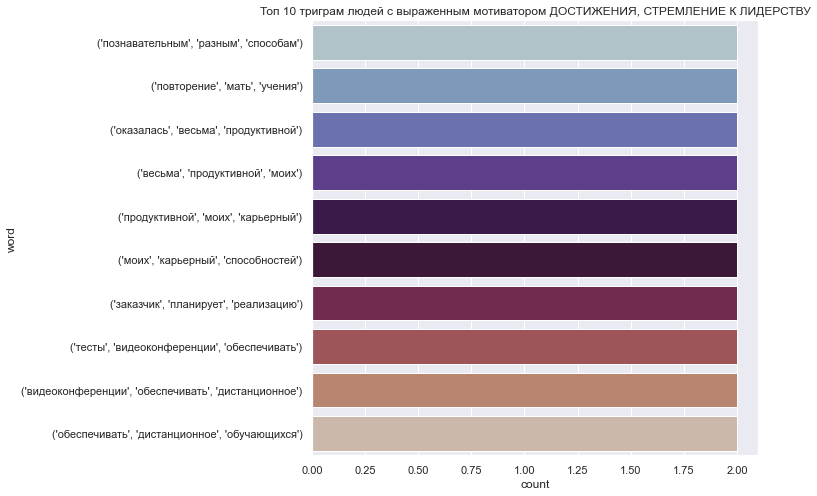

In [772]:
plot_trigrams('достижение','Топ 10 триграм людей с выраженным мотиватором ДОСТИЖЕНИЯ, СТРЕМЛЕНИЕ К ЛИДЕРСТВУ')

Триграмы для мотиваторов "достижения" и "преодоления сложностей" перекликаются. Выглядит логично. Скорее всего, человек, склонный достигать успехов, сталкивается с трудностями и преодолевает их.

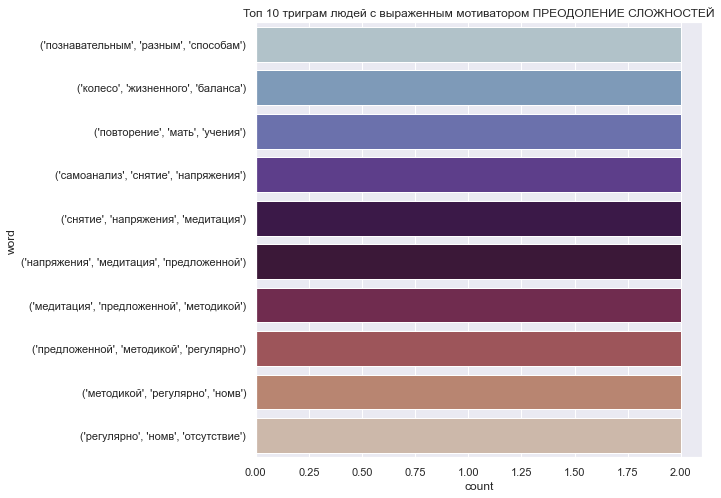

In [773]:
plot_trigrams('преодоление_сложностей','Топ 10 триграм людей с выраженным мотиватором ПРЕОДОЛЕНИЕ СЛОЖНОСТЕЙ')